In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA

sns.set_context('poster')
sns.set_style('white')

pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.simplefilter('ignore')

# for GMM
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture

import math
import matplotlib.mlab as mlab


In [2]:
def filter_by_coverage(cur_r, bad_percent, bad_samples):
    def filter_row(row):
        num_of_samples = len(row)
        valid = np.sum(np.array(([(min_coverage < row) & (row < max_coverage)])))
        return num_of_samples - valid <= bad_samples

    min_coverage = np.percentile(cur_r, bad_percent, axis=0)
    max_coverage = np.percentile(cur_r, 100-bad_percent, axis=0)
    good_coverage = np.array([filter_row(row) for row in cur_r])
    return good_coverage

In [3]:
r = np.genfromtxt("infant_gut/infant_gut_pure_without_ref/matrices/R_all", dtype=int, delimiter=' ')
x = np.genfromtxt("infant_gut/infant_gut_pure_without_ref/matrices/X_all", dtype=int, delimiter=' ')
names = ["strain 1", "strain 3", "strain 4"]
num_of_strains = len(names)

print("%s sites" % len(r))

54466 sites


In [4]:
mask = x[:, 0:(num_of_strains-1)]
mask[mask > 0] = 1
r = np.delete(r, [i for i in range(num_of_strains)], axis=1)
x = np.delete(x, [i for i in range(num_of_strains)], axis=1)

In [5]:
Ncut = 6
print("Delete zero and almost zero profiles:")
good_ind = [i for i in range(np.shape(x)[0]) 
            if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
print(len(good_ind), "remained")

x = x[good_ind, :]
r = r[good_ind, :]
mask = mask[good_ind, :]

Delete zero and almost zero profiles:
13860 remained


In [6]:
f = np.divide(x, r)

good_coverage = filter_by_coverage(r, 20, 2)
mask_filtered = mask[good_coverage, :]

f_filtered = f[good_coverage, :]
print(len(f_filtered), "remained")

genotypes = f_filtered.T

3655 remained


In [7]:
strain1 = list(map(float, "0.73 0.74 0.04 0.13 0.17 0.04 0.32 0.75 0.30 0.20 0.0".split()))
strain3 = list(map(float, "0.24 0.20 0.95 0.80 0.80 0.93 0.52 0.19 0.64 0.65 1.0".split()))
strain4 = list(map(float, "0.03 0.06 0.02 0.07 0.03 0.02 0.16 0.06 0.06 0.15 0.0".split()))
num_samples = len(strain1)

real_freqs = np.array((strain1, strain3, strain4))

for i, f in zip(range(1, num_samples+1), np.max(real_freqs, axis = 0)):
    print(i, f)

1 0.73
2 0.74
3 0.95
4 0.8
5 0.8
6 0.93
7 0.52
8 0.75
9 0.64
10 0.65
11 1.0


In [8]:
print(real_freqs)

[[ 0.73  0.74  0.04  0.13  0.17  0.04  0.32  0.75  0.3   0.2   0.  ]
 [ 0.24  0.2   0.95  0.8   0.8   0.93  0.52  0.19  0.64  0.65  1.  ]
 [ 0.03  0.06  0.02  0.07  0.03  0.02  0.16  0.06  0.06  0.15  0.  ]]


In [202]:
print(real_freqs[:,0])

[ 0.730  0.240  0.030]


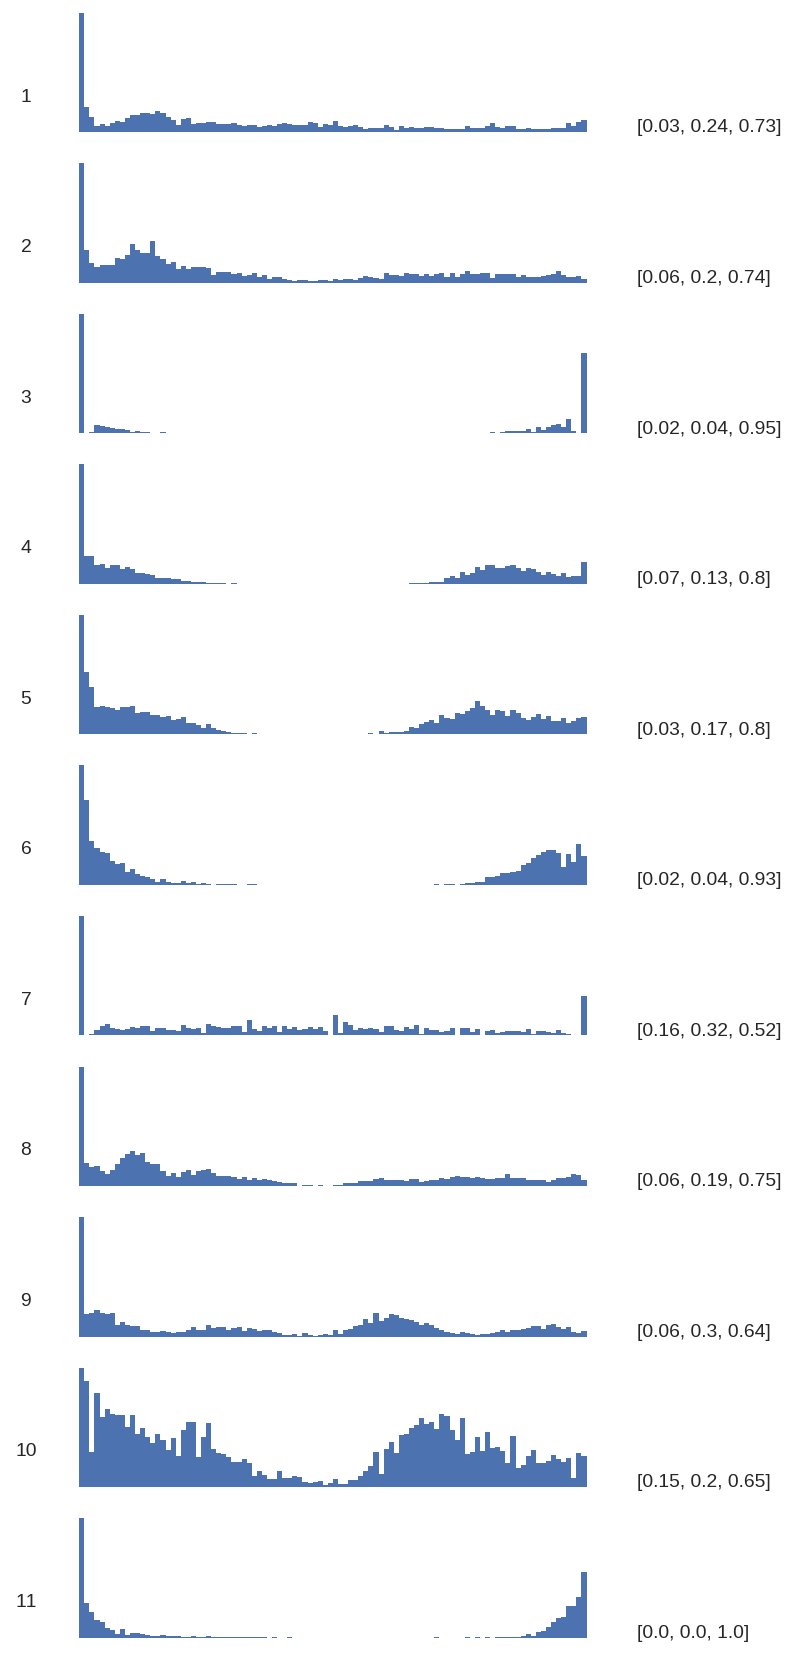

In [204]:
f, axarr = plt.subplots(len(genotypes), sharex=True)

for i in range(len(genotypes)):
    axarr[i].hist(genotypes[i], bins=100);
    axarr[i].axis('off')
    axarr[i].set_title(i+1, x=-0.05, y=0.2)
    axarr[i].text(1.1, 0.65, [float('{:.2f}'.format(m)) for m in sorted(real_freqs[:,i])])
    #axarr[i].set_xlim((0.03, 1.))
    
f.set_figheight(30)
f.set_figwidth(10)

In [118]:
X = genotypes[8].reshape((len(genotypes[8]), 1))

[0.03, 0.12, 0.86]


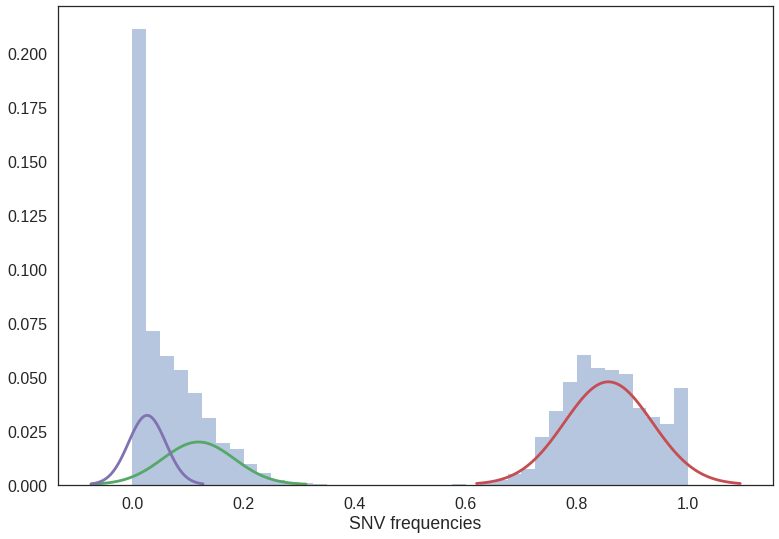

In [284]:
def plot_model_2(sample, covariance_type):
    X = genotypes[sample].reshape((len(genotypes[sample]), 1))
    
    model = mixture.BayesianGaussianMixture(n_components=20, 
                                            covariance_type=covariance_type, 
                                            tol=0.001, 
                                            reg_covar=1e-06, 
                                            max_iter=1000, 
                                            n_init=1, 
                                            init_params='kmeans', 
                                            weight_concentration_prior_type='dirichlet_process', 
                                            weight_concentration_prior=None, 
                                            mean_precision_prior=None, 
                                            mean_prior=None, 
                                            degrees_of_freedom_prior=None, 
                                            covariance_prior=None, 
                                            random_state=None, 
                                            warm_start=False, 
                                            verbose=0, verbose_interval=10)
    model.fit(X)
    
    Y_ = set(model.predict(X))
    
    model.means_ = model.means_.flatten()
    model.covariances_ = model.covariances_.flatten()
    
    weights = np.ones_like(X)/float(len(X))
    plt.hist(X, 40, weights=weights, alpha=0.4);

    mus = []
    ws = []
    for i in Y_:
        #if model.weights_[i] < 0.02:
        #    print("one more component")
        #    continue
        mu = model.means_[i]
        mus.append(mu)
        ws.append(model.weights_[i])
        variance = model.covariances_[i]
        sigma = math.sqrt(variance)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        pdf = mlab.normpdf(x, mu, sigma)
        plt.plot(x,((pdf / np.max(pdf))* model.weights_[i])/10)
        
    plt.xlabel("SNV frequencies")
    
    print([float('{:.2f}'.format(m)) for m in sorted(mus)])
    #print([float('{:.4f}'.format(w)) for w in sorted(ws)])
    
plot_model_2(3, 'spherical')

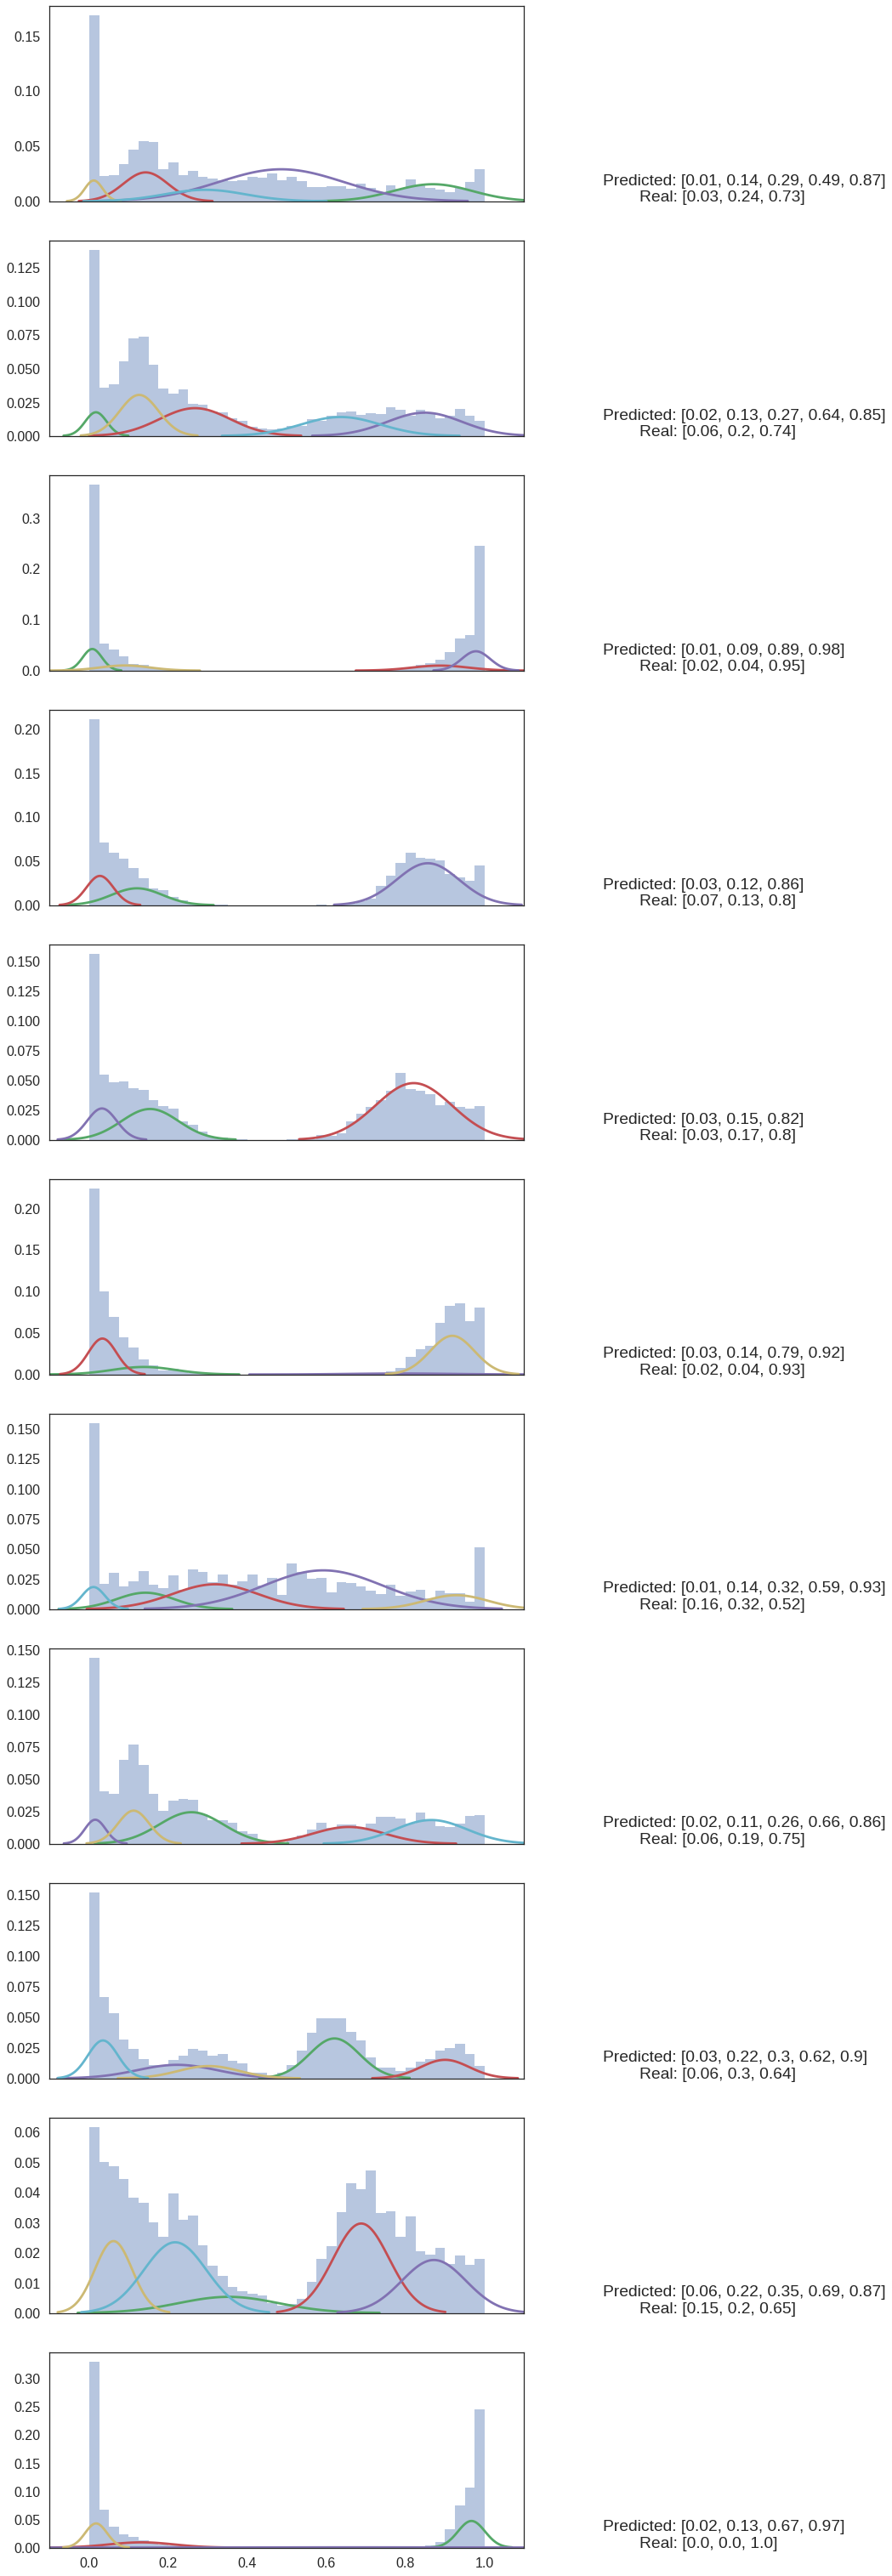

In [287]:
num_of_samples = 11

f, axarr = plt.subplots(num_of_samples, sharex=True)

for sample in range(num_of_samples):
    
    X = genotypes[sample].reshape((len(genotypes[sample]), 1))
    
    model = mixture.BayesianGaussianMixture(n_components=20, 
                                            covariance_type='spherical', 
                                            tol=0.001, 
                                            reg_covar=1e-06, 
                                            max_iter=1000, 
                                            n_init=3, 
                                            init_params='kmeans', 
                                            weight_concentration_prior_type='dirichlet_process', 
                                            weight_concentration_prior=None, 
                                            mean_precision_prior=None, 
                                            mean_prior=None, 
                                            degrees_of_freedom_prior=None, 
                                            covariance_prior=None, 
                                            random_state=None, 
                                            warm_start=False, 
                                            verbose=0, verbose_interval=10)
    model.fit(X)
    
    Y_ = set(model.predict(X))
    
    model.means_ = model.means_.flatten()
    model.covariances_ = model.covariances_.flatten()
    
    weights = np.ones_like(X)/float(len(X))
    axarr[sample].hist(X, 40, weights=weights, alpha=0.4);

    mus = []
    ws = []
    for i in Y_:
        #if model.weights_[i] < 0.02:
        #    print("one more component")
        #    continue
        mu = model.means_[i]
        mus.append(mu)
        ws.append(model.weights_[i])
        variance = model.covariances_[i]
        sigma = math.sqrt(variance)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        pdf = mlab.normpdf(x, mu, sigma)
        axarr[sample].plot(x,((pdf / np.max(pdf))* model.weights_[i])/10)
        
    axarr[sample].text(1.3, 0.0, 
                       'Predicted: ' + str([float('{:.2f}'.format(m)) for m in sorted(mus)]) +
                       '\n' +
                       '        Real: ' + str([float('{:.2f}'.format(m)) for m in sorted(real_freqs[:,sample])]))
    
    axarr[sample].set_xlim((-0.1, 1.1))
    
f.set_figheight(5 * num_of_samples)
f.set_figwidth(10)

In [296]:
a = genotypes[0]
((0.4 < a) & (a < 0.6)).sum() / len(a)

0.15157318741450068

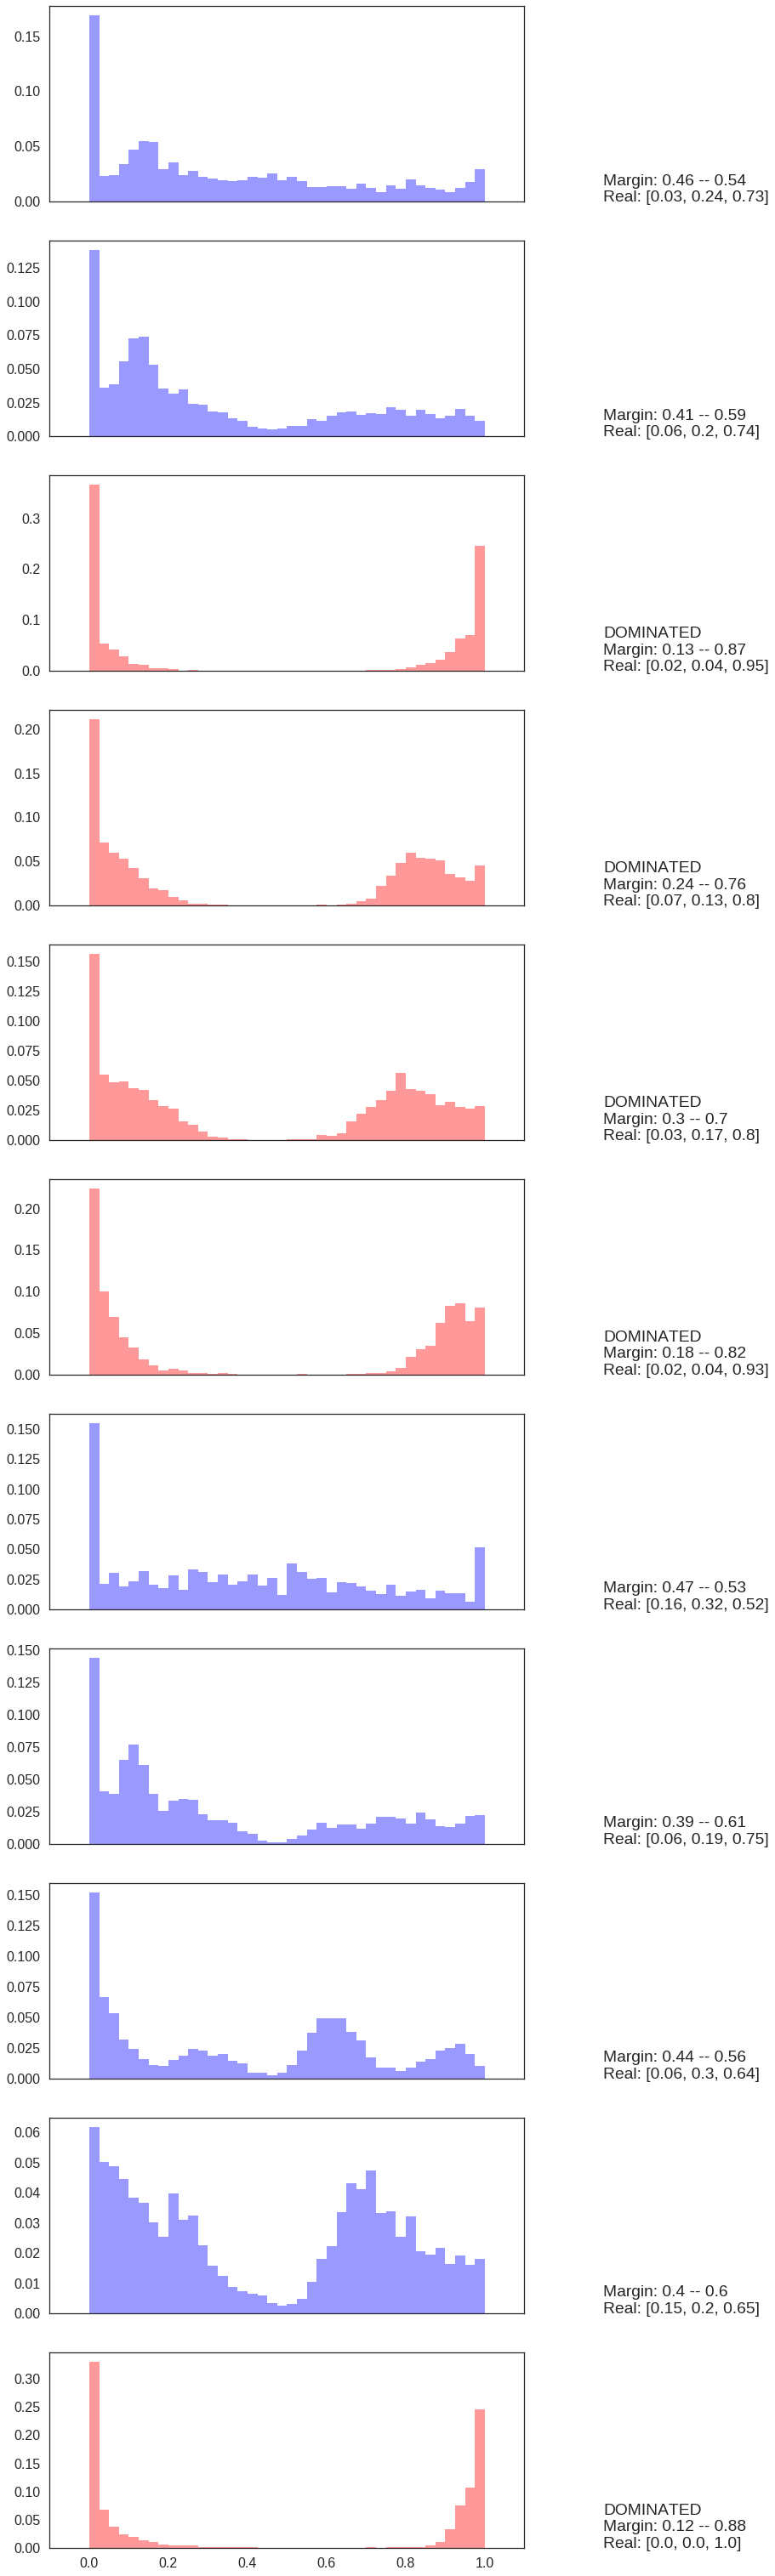

In [307]:
num_of_samples = 11

f, axarr = plt.subplots(num_of_samples, sharex=True)
eps = 0.01

for sample in range(num_of_samples):
    
    X = genotypes[sample]
    
    margin = eps
    while ((0.5-margin < X) & (X < 0.5+margin)).sum() / len(X) < 0.05:
        margin += eps
    
    if 0.5 + margin >= 0.7:
        d_str = 'DOMINATED\n'
        color = 'red'
    else:
        color = 'blue'
        d_str = ''
    
    weights = np.ones_like(X)/float(len(X))
    axarr[sample].hist(X, 40, weights=weights, alpha=0.4, color=color);
        
    axarr[sample].text(1.3, 0.0, d_str +
                       'Margin: ' + str(round(0.5-margin,2)) + ' -- ' + str(round(0.5+margin,2)) + '\n' +
                       'Real: ' + str([float('{:.2f}'.format(m)) for m in sorted(real_freqs[:,sample])]))
    
    axarr[sample].set_xlim((-0.1, 1.1))
    
f.set_figheight(5 * num_of_samples)
f.set_figwidth(10)